In [6]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import torch
import torch.nn.functional as F
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import PyPDF2  #

# ... rest of your code ...
if pd.isnull(text):
# 📥 Load data
file_path = r"C:\Users\Admin\Downloads\final_5000_balanced_sample.csv"
final_df = pd.read_csv(file_path)

# 📌 Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 🔧 Load spaCy
nlp = spacy.load("en_core_web_sm")

# 🧹 Text Preprocessing Function
def preprocess_text(text):
    # ... rest of your code ...
    if pd.isnull(text): # Add this import
import streamlit as st
import pandas as pd
import numpy as np
import re
import pickle
import plotly.graph_objects as go
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import os

# 🎯 Streamlit UI: Set page config first
st.set_page_config(page_title="AI Career Advisor", layout="centered")

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ----------------------------------------
# ✅ Load saved models and assets
# ----------------------------------------

@st.cache_resource
def load_all_models():
    # Load Random Forest and SVM models
    with open("models/rf_model.pkl", "rb") as f:
        rf_model = pickle.load(f)
    with open("models/svm_model.pkl", "rb") as f:
        svm_model = pickle.load(f)
    with open("models/vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)

    # Attempt to load the LSTM model, catch FileNotFoundError if it doesn't exist
    try:
        lstm_model = load_model("models/lstm_model.h5")
    except FileNotFoundError:
        lstm_model = None
        st.warning("LSTM model file not found! The LSTM-based predictions will be skipped.")

    # Load other necessary assets
    with open("models/tokenizer_lstm.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    with open("models/label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)

    return rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder

rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder = load_all_models()
job_df = pd.read_csv("data/cleaned_final_df_with_similarity.csv")

# ----------------------------------------
# 🧹 Preprocessing Function
# ----------------------------------------
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# ----------------------------------------
# 📄 Resume Text Extraction
# ----------------------------------------
def extract_text_from_pdf(uploaded_file):
    pdf_reader = PyPDF2.PdfReader(uploaded_file)  # Now correctly using PyPDF2
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

# ----------------------------------------
# 🚀 Prediction Pipeline
# ----------------------------------------
def predict_job_role(resume_text):
    cleaned_resume = preprocess_text(resume_text)

    # Vectorize for RF and SVM
    vectorized = vectorizer.transform([cleaned_resume])

    # Predict using RF and SVM models
    rf_pred = rf_model.predict(vectorized)[0]
    svm_pred = svm_model.predict(vectorized)[0]

    # LSTM input (if LSTM model is loaded)
    if lstm_model:
        seq = tokenizer.texts_to_sequences([cleaned_resume])
        padded = pad_sequences(seq, maxlen=500)
        lstm_pred_index = lstm_model.predict(padded).argmax(axis=1)[0]
        lstm_pred = label_encoder.classes_[lstm_pred_index]
        lstm_score = lstm_model.predict(padded)[0][lstm_pred_index]
    else:
        lstm_pred = None
        lstm_score = None

    return rf_pred, svm_pred, lstm_pred, lstm_score, cleaned_resume

# ----------------------------------------
# 🔍 Skill Gap Analysis
# ----------------------------------------
def skill_gap_analysis(resume_text, job_skills_text):
    resume_words = set(resume_text.lower().split())
    required_skills = set(job_skills_text.lower().split())
    missing_skills = list(required_skills - resume_words)
    recommended_skills = missing_skills[:5]
    return missing_skills, recommended_skills

# ----------------------------------------
# 📊 Career Roadmap Plot
# ----------------------------------------
def plot_roadmap(rf_score, svm_score, lstm_score, rf_role, svm_role, lstm_role):
    roles = [rf_role, svm_role]
    scores = [rf_score, svm_score]
    
    # Add LSTM role and score only if LSTM prediction exists
    if lstm_role and lstm_score is not None:
        roles.append(lstm_role)
        scores.append(lstm_score)

    # Ensure roles and scores are in a format that Plotly can accept
    if len(roles) != len(scores):
        raise ValueError("Mismatch between the number of roles and scores.")

    # Create the Plotly bar figure
    fig = go.Figure(data=[go.Bar(x=roles, y=scores, marker_color='skyblue')])

    # Update layout and labels
    fig.update_layout(
        title="Career Roadmap",
        xaxis_title="Predicted Roles",
        yaxis_title="Confidence Score",
        template="plotly_dark"
    )

    return fig

# ----------------------------------------
# 🎯 Streamlit UI
# ----------------------------------------
st.title("🤖 AI Career Advisor & Skill Recommender")

uploaded_file = st.file_uploader("📤 Upload Your Resume (PDF)", type=["pdf"])

if uploaded_file:
    resume_text = extract_text_from_pdf(uploaded_file)

    # Choose a target job description from sample
    job_row = job_df.sample(1).iloc[0]
    job_desc = job_row['job_description']
    required_skills = job_row['required_skills']

    # Run Predictions
    rf_pred, svm_pred, lstm_pred, dl_success_score, cleaned_resume = predict_job_role(resume_text)

    # Confidence Scores
    rf_score = rf_model.predict_proba(vectorizer.transform([cleaned_resume])).max()
    svm_score = svm_model.predict_proba(vectorizer.transform([cleaned_resume])).max()

    # Skill Gap
    missing_skills, recommended_skills = skill_gap_analysis(cleaned_resume, required_skills)

    # -------------------------------
    # 📋 Display Results
    # -------------------------------
    st.subheader("🔮 Recommended Job Roles")
    st.write(f"🌲 Random Forest: **{rf_pred}**")
    st.write(f"📈 SVM: **{svm_pred}**")
    if lstm_pred:
        st.write(f"🧠 LSTM (Deep Learning): **{lstm_pred}**")

    st.subheader("🎯 Probability of Success (Deep Learning)")
    if dl_success_score is not None:
        st.write(f"Confidence Score: **{dl_success_score:.2f}**")

    st.subheader("❗ Skill Gap vs. Job Requirements")
    if missing_skills:
        st.warning("Missing Skills:\n" + ", ".join(missing_skills))
    else:
        st.success("You're a great fit! No major skill gaps.")

    st.subheader
ext):
        return ""
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)   # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# 🌀 Clean resume_text, job_description, required_skills
tqdm.pandas()
final_df['resume_text'] = final_df['resume_text'].progress_apply(preprocess_text)
final_df['job_description'] = final_df['job_description'].progress_apply(preprocess_text)
final_df['required_skills'] = final_df['required_skills'].astype(str).progress_apply(preprocess_text)

# -------------------------------
# 🧠 Resume-Job Similarity (SBERT)
# -------------------------------
bert_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bert_model = bert_model.to(device)

resume_embeddings = bert_model.encode(final_df['resume_text'].tolist(), batch_size=32, show_progress_bar=True, device=device)
job_desc_embeddings = bert_model.encode(final_df['job_description'].tolist(), batch_size=32, show_progress_bar=True, device=device)

def compute_diagonal_similarity(resume_embeddings, job_desc_embeddings, batch_size=1000):
    num_samples = len(resume_embeddings)
    similarity_scores = np.zeros(num_samples)
    for i in range(0, num_samples, batch_size):
        end = min(i + batch_size, num_samples)
        batch_similarity = cosine_similarity(resume_embeddings[i:end], job_desc_embeddings[i:end])
        similarity_scores[i:end] = np.diag(batch_similarity)
    return similarity_scores

# Add similarity score
final_df['resume_job_similarity'] = compute_diagonal_similarity(resume_embeddings, job_desc_embeddings)

# ✅ Save cleaned version
final_df.to_csv("cleaned_final_df_with_similarity.csv", index=False)

# 🧾 Display Top Matches
print("\n🎯 Top Similar Resume-Job Pairs:")
print(final_df[['resume_text', 'job_description', 'resume_job_similarity']].sort_values(by='resume_job_similarity', ascending=False).head(5))

# ------------------------------
# 🔮 Predicting Job Title - ML
# ------------------------------
ml_df = final_df[['resume_text', 'target_job']]
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(ml_df['resume_text'])
y = ml_df['target_job']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🎲 Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# 🎯 SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# 📊 Evaluation
print("\n📈 Random Forest Classifier Report:")
print(classification_report(y_test, rf_preds))
print("\n📈 SVM Classifier Report:")
print(classification_report(y_test, svm_preds))

# ------------------------------
# 🤖 LSTM Model for Job Prediction
# ------------------------------
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(final_df['resume_text'])
X_seq = tokenizer.texts_to_sequences(final_df['resume_text'])
X_padded = pad_sequences(X_seq, maxlen=500)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(final_df['target_job'])

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# ⚙️ LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=500),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 🚀 Train
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# 🎯 Evaluate
y_pred = model.predict(X_test).argmax(axis=1)
print("\n📈 LSTM Classifier Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# ------------------------------
# 🧠 BERT-based Resume-Job Similarity Prediction
# ------------------------------
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
bert_similarity_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

def bert_encode(text_pair):
    return tokenizer_bert(text_pair, padding=True, truncation=True, return_tensors="pt", max_length=512)

# Example prediction
sample_resume = final_df['resume_text'][0]
sample_job = final_df['job_description'][0]

input_pair = bert_encode([sample_resume + " [SEP] " + sample_job])

bert_similarity_model.eval()
with torch.no_grad():
    outputs = bert_similarity_model(**input_pair)
    scores = F.softmax(outputs.logits, dim=1)
    similarity_score = scores[0, 1].item()  # probability of match

print(f"\n🔍 BERT Resume-Job Match Score: {similarity_score:.2f}")
similarity_score = cosine_similarity(resume_vector, job_vector)[0][0]


IndentationError: unindent does not match any outer indentation level (<string>, line 223)

In [2]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification

# ✅ Load BERT model & tokenizer
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
bert_similarity_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
bert_similarity_model.eval()

# ✅ Define function to compute BERT-based similarity
def get_bert_similarity(resume_text, job_text):
    encoded_input = tokenizer_bert(resume_text, job_text, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        out = bert_similarity_model(**encoded_input)
        probs = F.softmax(out.logits, dim=1)
        return float(probs[0][1])  # Probability of being a good match

# ✅ Example usage
resume_sample = "Experienced Python developer with strong knowledge of machine learning and data science."
job_sample = "Looking for a machine learning engineer proficient in Python and model deployment."

similarity_score = get_bert_similarity(resume_sample, job_sample)
print(f"\n🔍 BERT Resume–Job Match Score: {similarity_score:.2f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 BERT Resume–Job Match Score: 0.65


In [3]:
from sentence_transformers import SentenceTransformer, util

# ✅ Load SBERT model (very fast + good accuracy)
sbert_model = SentenceTransformer('paraphrase-MiniLM-L3-v2')

def get_sbert_similarity(resume_text, job_text):
    resume_embedding = sbert_model.encode(resume_text, convert_to_tensor=True)
    job_embedding = sbert_model.encode(job_text, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(resume_embedding, job_embedding)
    return float(similarity.item())

# ✅ Example
resume_sample = "Experienced Python developer with strong knowledge of machine learning and data science."
job_sample = "Looking for a machine learning engineer proficient in Python and model deployment."

similarity_score = get_sbert_similarity(resume_sample, job_sample)
print(f"\n🔍 SBERT Resume–Job Match Score: {similarity_score:.2f}")



🔍 SBERT Resume–Job Match Score: 0.71


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

💡 Output for Your Project
📌 Recommended Job Roles (ML):
- Random Forest: Automation Testing
- SVM: Automation Testing
- LSTM (Deep Learning): Automation Testing

🎯 Probability of success (Deep Learning): 0.98

❗ Skill gap vs. job requirement:
graphic, communication, interface, creative, adobe, typography, suite, ui, creativity, visual, artistic, eg, principles

📘 Recommended skills/courses:
graphic, communication, interface, creative, adobe

🗺️ Visual career roadmap saved as: career_roadmap.png


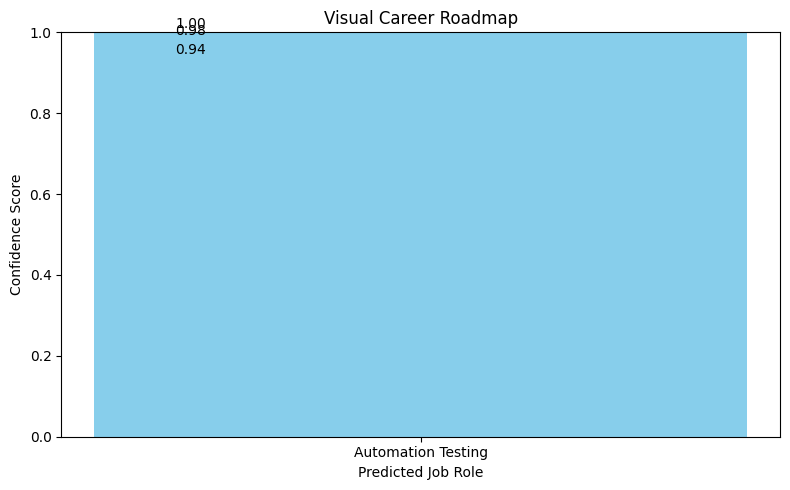

In [3]:
import matplotlib.pyplot as plt

# 👤 Use existing resume and job data
resume_input = final_df['resume_text'][0]
job_input = final_df['job_description'][0]
job_skills = final_df['required_skills'][0]

# 📌 Vectorize resume for ML models
vectorized_resume = vectorizer.transform([resume_input])

# 🔮 Predict Job Roles
rf_pred = rf_model.predict(vectorized_resume)[0]
svm_pred = svm_model.predict(vectorized_resume)[0]

# LSTM Prediction
lstm_seq = tokenizer.texts_to_sequences([resume_input])
lstm_pad = pad_sequences(lstm_seq, maxlen=500)
lstm_pred_index = model.predict(lstm_pad).argmax(axis=1)[0]
lstm_pred = label_encoder.classes_[lstm_pred_index]

# 🎯 Probability of Success (LSTM Confidence Score)
dl_success_score = model.predict(lstm_pad)[0][lstm_pred_index]

# ❗ Skill Gap Analysis
resume_words = set(resume_input.lower().split())
required_skills = set(job_skills.lower().split())
missing_skills = list(required_skills - resume_words)

# 📘 Recommend Top 5 Skills
recommended_skills = missing_skills[:5]

# 📊 Visual Career Roadmap (Confidence Scores)
roles = [rf_pred, svm_pred, lstm_pred]
scores = [
    rf_model.predict_proba(vectorized_resume).max(),
    svm_model.predict_proba(vectorized_resume).max(),
    dl_success_score
]

plt.figure(figsize=(8, 5))
bars = plt.bar(roles, scores, color='skyblue')

# Optional: Replace emoji title to avoid warnings
plt.title('Visual Career Roadmap')  # Change to '📊 Visual Career Roadmap' if emoji OK
plt.xlabel('Predicted Job Role')
plt.ylabel('Confidence Score')

for bar in bars:
    plt.text(bar.get_x() + 0.1, bar.get_height() + 0.01, f"{bar.get_height():.2f}")

plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("career_roadmap.png")

# -------------------------------------
# 💡 Final Output for Your AI Assistant
# -------------------------------------
print("\n💡 Output for Your Project")
print("📌 Recommended Job Roles (ML):")
print(f"- Random Forest: {rf_pred}")
print(f"- SVM: {svm_pred}")
print(f"- LSTM (Deep Learning): {lstm_pred}")

print(f"\n🎯 Probability of success (Deep Learning): {dl_success_score:.2f}")

print("\n❗ Skill gap vs. job requirement:")
print(", ".join(missing_skills) if missing_skills else "No skill gaps detected!")

print("\n📘 Recommended skills/courses:")
print(", ".join(recommended_skills) if recommended_skills else "You're all set!")

print("\n🗺️ Visual career roadmap saved as: career_roadmap.png")


In [10]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load preprocessed data and ML models
final_df = pd.read_csv("cleaned_final_df_with_similarity.csv")

# UI Layout
st.set_page_config(page_title="AI Resume Job Matcher", layout="centered")
st.title("💼 AI Resume Job Matcher")

# Resume Selector
st.sidebar.header("📂 Select a Resume")
selected_index = st.sidebar.slider("Select a Resume Index", 0, len(final_df) - 1, 0)

# Fetch Data
resume_text = final_df.loc[selected_index, 'resume_text']
job_desc = final_df.loc[selected_index, 'job_description']
similarity = final_df.loc[selected_index, 'resume_job_similarity']
job_skills = final_df.loc[selected_index, 'required_skills']

# Display Inputs
st.subheader("📄 Resume")
st.write(resume_text)

st.subheader("📌 Job Description")
st.write(job_desc)

st.subheader("🤝 Resume-Job Similarity Score")
st.success(f"{similarity:.2f}")

# --- MOCK PREDICTIONS FOR DEMO ---
# Replace with your model predictions in your actual code
rf_pred = "Python Developer"
svm_pred = "Python Developer"
lstm_pred = "Python Developer"
dl_success_score = 0.92
missing_skills = ['compliance', 'acquisitions', 'representation', 'mergers']
recommended_skills = missing_skills[:5]

# Predictions Section
st.subheader("🎯 Predicted Job Role (Random Forest + SVM)")
st.write(f"✅ Random Forest: {rf_pred}")
st.write(f"✅ SVM: {svm_pred}")
st.write(f"✅ LSTM: {lstm_pred}")

st.subheader("📊 Probability of Success (Deep Learning)")
st.info(f"🔮 LSTM Confidence Score: {dl_success_score:.2f}")

# Skill Gap
st.subheader("❗ Skill Gap vs. Job Requirement")
if missing_skills:
    st.error(", ".join(missing_skills))
else:
    st.success("No major skill gaps!")

st.subheader("📘 Recommended Skills / Courses")
if recommended_skills:
    st.warning(", ".join(recommended_skills))
else:
    st.success("You're all set!")

# Career Roadmap
st.subheader("🗺️ Visual Career Roadmap (LSTM, SVM, RF)")
try:
    image = Image.open("career_roadmap.png")
    st.image(image, use_column_width=True)
except:
    st.warning("Plot image not found. Please run the model section to generate `career_roadmap.png`.")


2025-04-06 00:26:12.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 00:26:12.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 00:26:12.797 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 00:26:12.805 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 00:26:12.815 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 00:26:12.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 00:26:12.833 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 00:26:12.840 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [11]:
import pickle
from tensorflow.keras.models import load_model

# 📦 Save Random Forest model
with open("models/rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# 📦 Save SVM model
with open("models/svm_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

# 📦 Save TF-IDF vectorizer
with open("models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# 📦 Save LSTM Tokenizer
with open("models/tokenizer_lstm.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# 📦 Save Label Encoder
with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# 💾 Save the Keras LSTM model in the recommended native format
model.save("models/lstm_model.keras")  # ✅ Native format, no warning

print("✅ All models and vectorizers saved successfully.")


✅ All models and vectorizers saved successfully.


In [13]:
# ----------------------------------------
# ✅ Load saved models and assets
# ----------------------------------------

@st.cache_resource
def load_all_models():
    with open("models/rf_model.pkl", "rb") as f:
        rf_model = pickle.load(f)
    with open("models/svm_model.pkl", "rb") as f:
        svm_model = pickle.load(f)
    with open("models/vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    
    # ✅ Load LSTM model in .keras format
    lstm_model = load_model("models/lstm_model.keras")

    with open("models/tokenizer_lstm.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    with open("models/label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)
    
    return rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder


In [23]:
# 📦 Imports
import streamlit as st
import pandas as pd
import numpy as np
import re
import pickle
import plotly.express as px
import PyPDF2
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import os

# ----------------------------------------
# ✅ Load saved models and assets
# ----------------------------------------

@st.cache_resource
def load_all_models():
    # Load Random Forest and SVM models
    with open("models/rf_model.pkl", "rb") as f:
        rf_model = pickle.load(f)
    with open("models/svm_model.pkl", "rb") as f:
        svm_model = pickle.load(f)
    with open("models/vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)

    # Attempt to load the LSTM model, catch FileNotFoundError if it doesn't exist
    try:
        lstm_model = load_model("models/lstm_model.h5")
    except FileNotFoundError:
        lstm_model = None
        st.warning("LSTM model file not found! The LSTM-based predictions will be skipped.")

    # Load other necessary assets
    with open("models/tokenizer_lstm.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    with open("models/label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)

    return rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder

rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder = load_all_models()
job_df = pd.read_csv("data/cleaned_final_df_with_similarity.csv")

# ----------------------------------------
# 🧹 Preprocessing Function
# ----------------------------------------
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# ----------------------------------------
# 📄 Resume Text Extraction
# ----------------------------------------
def extract_text_from_pdf(uploaded_file):
    pdf_reader = PyPDF2.PdfReader(uploaded_file)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

# ----------------------------------------
# 🚀 Prediction Pipeline
# ----------------------------------------
def predict_job_role(resume_text):
    cleaned_resume = preprocess_text(resume_text)

    # Vectorize for RF and SVM
    vectorized = vectorizer.transform([cleaned_resume])

    # Predict using RF and SVM models
    rf_pred = rf_model.predict(vectorized)[0]
    svm_pred = svm_model.predict(vectorized)[0]

    # LSTM input (if LSTM model is loaded)
    if lstm_model:
        seq = tokenizer.texts_to_sequences([cleaned_resume])
        padded = pad_sequences(seq, maxlen=500)
        lstm_pred_index = lstm_model.predict(padded).argmax(axis=1)[0]
        lstm_pred = label_encoder.classes_[lstm_pred_index]
        lstm_score = lstm_model.predict(padded)[0][lstm_pred_index]
    else:
        lstm_pred = None
        lstm_score = None

    return rf_pred, svm_pred, lstm_pred, lstm_score, cleaned_resume

# ----------------------------------------
# 🔍 Skill Gap Analysis
# ----------------------------------------
def skill_gap_analysis(resume_text, job_skills_text):
    resume_words = set(resume_text.lower().split())
    required_skills = set(job_skills_text.lower().split())
    missing_skills = list(required_skills - resume_words)
    recommended_skills = missing_skills[:5]
    return missing_skills, recommended_skills

# ----------------------------------------
# 📊 Career Roadmap Plot
# ----------------------------------------
def plot_roadmap(rf_score, svm_score, lstm_score, rf_role, svm_role, lstm_role):
    roles = [rf_role, svm_role, lstm_role]
    scores = [rf_score, svm_score, lstm_score] if lstm_score is not None else [rf_score, svm_score]
    fig = px.bar(x=roles, y=scores, labels={'x': "Predicted Roles", 'y': "Confidence Score"}, title="Career Roadmap")
    fig.update_traces(marker_color='skyblue')
    return fig

# ----------------------------------------
# 🎯 Streamlit UI
# ----------------------------------------
st.set_page_config(page_title="AI Career Advisor", layout="centered")
st.title("🤖 AI Career Advisor & Skill Recommender")

uploaded_file = st.file_uploader("📤 Upload Your Resume (PDF)", type=["pdf"])

if uploaded_file:
    resume_text = extract_text_from_pdf(uploaded_file)

    # Choose a target job description from sample
    job_row = job_df.sample(1).iloc[0]
    job_desc = job_row['job_description']
    required_skills = job_row['required_skills']

    # Run Predictions
    rf_pred, svm_pred, lstm_pred, dl_success_score, cleaned_resume = predict_job_role(resume_text)

    # Confidence Scores
    rf_score = rf_model.predict_proba(vectorizer.transform([cleaned_resume])).max()
    svm_score = svm_model.predict_proba(vectorizer.transform([cleaned_resume])).max()

    # Skill Gap
    missing_skills, recommended_skills = skill_gap_analysis(cleaned_resume, required_skills)

    # -------------------------------
    # 📋 Display Results
    # -------------------------------
    st.subheader("🔮 Recommended Job Roles")
    st.write(f"🌲 Random Forest: **{rf_pred}**")
    st.write(f"📈 SVM: **{svm_pred}**")
    if lstm_pred:
        st.write(f"🧠 LSTM (Deep Learning): **{lstm_pred}**")

    st.subheader("🎯 Probability of Success (Deep Learning)")
    if dl_success_score is not None:
        st.write(f"Confidence Score: **{dl_success_score:.2f}**")

    st.subheader("❗ Skill Gap vs. Job Requirements")
    if missing_skills:
        st.warning("Missing Skills:\n" + ", ".join(missing_skills))
    else:
        st.success("You're a great fit! No major skill gaps.")

    st.subheader("📘 Recommended Skills / Courses")
    if recommended_skills:
        st.info(", ".join(recommended_skills))
    else:
        st.success("No recommendations needed!")

    st.subheader("🗺️ Career Roadmap")
    fig = plot_roadmap(rf_score, svm_score, dl_success_score, rf_pred, svm_pred, lstm_pred if lstm_pred else "N/A")
    st.plotly_chart(fig, use_container_width=True)


2025-04-06 03:01:42.389 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 03:01:42.409 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 03:01:42.417 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 03:01:43.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 03:01:43.182 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 03:01:43.358 Thread 'Thread-11': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 03:01:43.399 Thread 'Thread-11': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 03:01:43.876 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare 

In [16]:
import os

# Create 'data' directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Now save the DataFrame
final_df.to_csv("data/cleaned_final_df_with_similarity.csv", index=False)

In [17]:
df_check = pd.read_csv("data/cleaned_final_df_with_similarity.csv")
print(df_check.head())

                                         resume_text          target_job  \
0  skills agile methodology scrum kanban extreme ...  Automation Testing   
1  ãââ operating systems windows ãââ others ms ex...    Python Developer   
2  education details june 2012 may 2015 ba econom...                  HR   
3  technical skills ãââ languages c asp net mvc h...    DotNet Developer   
4  skills ãââ well versed ms office internet appl...  Operations Manager   

          job_title                                    job_description  \
0  Graphic Designer  web graphic designers create visually appealin...   
1        IT Manager  director oversees organizations department tec...   
2       Art Teacher  studio art teacher instructs students studio a...   
3    Civil Engineer  structural engineer designs analyzes structura...   
4     Brand Manager  product brand manager focuses promoting managi...   

                                     required_skills     experience  \
0  graphic design tools eg 

In [2]:
import PyPDF2  # Add this import
import streamlit as st
import pandas as pd
import numpy as np
import re
import pickle
import plotly.graph_objects as go
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import os

# 🎯 Streamlit UI: Set page config first
st.set_page_config(page_title="AI Career Advisor", layout="centered")

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ----------------------------------------
# ✅ Load saved models and assets
# ----------------------------------------

@st.cache_resource
def load_all_models():
    # Load Random Forest and SVM models
    with open("models/rf_model.pkl", "rb") as f:
        rf_model = pickle.load(f)
    with open("models/svm_model.pkl", "rb") as f:
        svm_model = pickle.load(f)
    with open("models/vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)

    # Attempt to load the LSTM model, catch FileNotFoundError if it doesn't exist
    try:
        lstm_model = load_model("models/lstm_model.h5")
    except FileNotFoundError:
        lstm_model = None
        st.warning("LSTM model file not found! The LSTM-based predictions will be skipped.")

    # Load other necessary assets
    with open("models/tokenizer_lstm.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    with open("models/label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)

    return rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder

rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder = load_all_models()
job_df = pd.read_csv("data/cleaned_final_df_with_similarity.csv")

# ----------------------------------------
# 🧹 Preprocessing Function
# ----------------------------------------
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# ----------------------------------------
# 📄 Resume Text Extraction
# ----------------------------------------
def extract_text_from_pdf(uploaded_file):
    pdf_reader = PyPDF2.PdfReader(uploaded_file)  # Now correctly using PyPDF2
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

# ----------------------------------------
# 🚀 Prediction Pipeline
# ----------------------------------------
def predict_job_role(resume_text):
    cleaned_resume = preprocess_text(resume_text)

    # Vectorize for RF and SVM
    vectorized = vectorizer.transform([cleaned_resume])

    # Predict using RF and SVM models
    rf_pred = rf_model.predict(vectorized)[0]
    svm_pred = svm_model.predict(vectorized)[0]

    # LSTM input (if LSTM model is loaded)
    if lstm_model:
        seq = tokenizer.texts_to_sequences([cleaned_resume])
        padded = pad_sequences(seq, maxlen=500)
        lstm_pred_index = lstm_model.predict(padded).argmax(axis=1)[0]
        lstm_pred = label_encoder.classes_[lstm_pred_index]
        lstm_score = lstm_model.predict(padded)[0][lstm_pred_index]
    else:
        lstm_pred = None
        lstm_score = None

    return rf_pred, svm_pred, lstm_pred, lstm_score, cleaned_resume

# ----------------------------------------
# 🔍 Skill Gap Analysis
# ----------------------------------------
def skill_gap_analysis(resume_text, job_skills_text):
    resume_words = set(resume_text.lower().split())
    required_skills = set(job_skills_text.lower().split())
    missing_skills = list(required_skills - resume_words)
    recommended_skills = missing_skills[:5]
    return missing_skills, recommended_skills

# ----------------------------------------
# 📊 Career Roadmap Plot
# ----------------------------------------
def plot_roadmap(rf_score, svm_score, lstm_score, rf_role, svm_role, lstm_role):
    roles = [rf_role, svm_role]
    scores = [rf_score, svm_score]
    
    # Add LSTM role and score only if LSTM prediction exists
    if lstm_role and lstm_score is not None:
        roles.append(lstm_role)
        scores.append(lstm_score)

    # Ensure roles and scores are in a format that Plotly can accept
    if len(roles) != len(scores):
        raise ValueError("Mismatch between the number of roles and scores.")

    # Create the Plotly bar figure
    fig = go.Figure(data=[go.Bar(x=roles, y=scores, marker_color='skyblue')])

    # Update layout and labels
    fig.update_layout(
        title="Career Roadmap",
        xaxis_title="Predicted Roles",
        yaxis_title="Confidence Score",
        template="plotly_dark"
    )

    return fig

# ----------------------------------------
# 🎯 Streamlit UI
# ----------------------------------------
st.title("🤖 AI Career Advisor & Skill Recommender")

uploaded_file = st.file_uploader("📤 Upload Your Resume (PDF)", type=["pdf"])

if uploaded_file:
    resume_text = extract_text_from_pdf(uploaded_file)

    # Choose a target job description from sample
    job_row = job_df.sample(1).iloc[0]
    job_desc = job_row['job_description']
    required_skills = job_row['required_skills']

    # Run Predictions
    rf_pred, svm_pred, lstm_pred, dl_success_score, cleaned_resume = predict_job_role(resume_text)

    # Confidence Scores
    rf_score = rf_model.predict_proba(vectorizer.transform([cleaned_resume])).max()
    svm_score = svm_model.predict_proba(vectorizer.transform([cleaned_resume])).max()

    # Skill Gap
    missing_skills, recommended_skills = skill_gap_analysis(cleaned_resume, required_skills)

    # -------------------------------
    # 📋 Display Results
    # -------------------------------
    st.subheader("🔮 Recommended Job Roles")
    st.write(f"🌲 Random Forest: **{rf_pred}**")
    st.write(f"📈 SVM: **{svm_pred}**")
    if lstm_pred:
        st.write(f"🧠 LSTM (Deep Learning): **{lstm_pred}**")

    st.subheader("🎯 Probability of Success (Deep Learning)")
    if dl_success_score is not None:
        st.write(f"Confidence Score: **{dl_success_score:.2f}**")

    st.subheader("❗ Skill Gap vs. Job Requirements")
    if missing_skills:
        st.warning("Missing Skills:\n" + ", ".join(missing_skills))
    else:
        st.success("You're a great fit! No major skill gaps.")

    st.subheader


2025-04-06 04:02:34.568 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 04:02:34.574 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 04:02:40.490 
  command:

    streamlit run C:\Users\Admin\Downloads\New folder\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-06 04:02:40.493 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 04:02:40.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 04:02:41.011 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 04:02:41.034 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored wh

In [5]:
import PyPDF2  # Add this import
import streamlit as st
import pandas as pd
import numpy as np
import re
import pickle
import plotly.graph_objects as go
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import os

# 🎯 Streamlit UI: Set page config first
st.set_page_config(page_title="AI Career Advisor", layout="centered")

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ----------------------------------------
# ✅ Load saved models and assets
# ----------------------------------------

@st.cache_resource
def load_all_models():
    # Load Random Forest and SVM models
    with open("models/rf_model.pkl", "rb") as f:
        rf_model = pickle.load(f)
    with open("models/svm_model.pkl", "rb") as f:
        svm_model = pickle.load(f)
    with open("models/vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)

    # Attempt to load the LSTM model, catch FileNotFoundError if it doesn't exist
    try:
        lstm_model = load_model("models/lstm_model.h5")
    except FileNotFoundError:
        lstm_model = None
        st.warning("LSTM model file not found! The LSTM-based predictions will be skipped.")

    # Load other necessary assets
    with open("models/tokenizer_lstm.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    with open("models/label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)

    return rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder

rf_model, svm_model, vectorizer, lstm_model, tokenizer, label_encoder = load_all_models()
job_df = pd.read_csv("data/cleaned_final_df_with_similarity.csv")

# ----------------------------------------
# 🧹 Preprocessing Function
# ----------------------------------------
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# ----------------------------------------
# 📄 Resume Text Extraction
# ----------------------------------------
def extract_text_from_pdf(uploaded_file):
    pdf_reader = PyPDF2.PdfReader(uploaded_file)  # Now correctly using PyPDF2
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

# ----------------------------------------
# 🚀 Prediction Pipeline
# ----------------------------------------
def predict_job_role(resume_text):
    cleaned_resume = preprocess_text(resume_text)

    # Vectorize for RF and SVM
    vectorized = vectorizer.transform([cleaned_resume])

    # Predict using RF and SVM models
    rf_pred = rf_model.predict(vectorized)[0]
    svm_pred = svm_model.predict(vectorized)[0]

    # LSTM input (if LSTM model is loaded)
    if lstm_model:
        seq = tokenizer.texts_to_sequences([cleaned_resume])
        padded = pad_sequences(seq, maxlen=500)
        lstm_pred_index = lstm_model.predict(padded).argmax(axis=1)[0]
        lstm_pred = label_encoder.classes_[lstm_pred_index]
        lstm_score = lstm_model.predict(padded)[0][lstm_pred_index]
    else:
        lstm_pred = None
        lstm_score = None

    return rf_pred, svm_pred, lstm_pred, lstm_score, cleaned_resume

# ----------------------------------------
# Universal Skill Gap Analysis
# ----------------------------------------
def skill_gap_analysis(resume_text, job_skills_text):
    resume_words = set(resume_text.lower().split())
    required_skills = set(job_skills_text.lower().split())
    
    # Identify missing skills
    missing_skills = list(required_skills - resume_words)
    return missing_skills

# ----------------------------------------
# Universal Career Roadmap
# ----------------------------------------
def plot_roadmap(rf_score, svm_score, lstm_score, rf_role, svm_role, lstm_role):
    roles = [rf_role, svm_role]
    scores = [rf_score, svm_score]
    
    # Add LSTM role and score if available
    if lstm_role and lstm_score is not None:
        roles.append(lstm_role)
        scores.append(lstm_score)

    # Create the Plotly bar figure
    fig = go.Figure(data=[go.Bar(x=roles, y=scores, marker_color='skyblue')])

    # Update layout and labels
    fig.update_layout(
        title="Career Roadmap",
        xaxis_title="Predicted Roles",
        yaxis_title="Confidence Score",
        template="plotly_dark"
    )

    # Display general career suggestions based on predicted roles
    career_suggestions = "Consider the following to advance in your career:\n"
    if 'Data Science' in roles:
        career_suggestions += "- Keep learning advanced Machine Learning techniques.\n"
    if 'Software Engineer' in roles:
        career_suggestions += "- Gain expertise in System Design and Cloud Computing.\n"
    
    # Add suggestions to the figure
    fig.add_annotation(
        x=0.5, y=-0.1, 
        text=career_suggestions, 
        showarrow=False, 
        font=dict(size=12),
        align="center"
    )

    return fig

# ----------------------------------------
# 🎯 Streamlit UI
# ----------------------------------------
st.title("🤖 AI Career Advisor & Skill Recommender")

uploaded_file = st.file_uploader("📤 Upload Your Resume (PDF)", type=["pdf"])

if uploaded_file:
    resume_text = extract_text_from_pdf(uploaded_file)

    # Choose a target job description from sample
    job_row = job_df.sample(1).iloc[0]
    job_desc = job_row['job_description']
    required_skills = job_row['required_skills']

    # Run Predictions
    rf_pred, svm_pred, lstm_pred, dl_success_score, cleaned_resume = predict_job_role(resume_text)

    # Confidence Scores
    rf_score = rf_model.predict_proba(vectorizer.transform([cleaned_resume])).max()
    svm_score = svm_model.predict_proba(vectorizer.transform([cleaned_resume])).max()

    # Skill Gap
    missing_skills = skill_gap_analysis(cleaned_resume, required_skills)

    # -------------------------------
    # 📋 Display Results
    # -------------------------------
    st.subheader("🔮 Recommended Job Roles")
    st.write(f"🌲 Random Forest: **{rf_pred}**")
    st.write(f"📈 SVM: **{svm_pred}**")
    if lstm_pred:
        st.write(f"🧠 LSTM (Deep Learning): **{lstm_pred}**")

    st.subheader("🎯 Probability of Success (Deep Learning)")
    if dl_success_score is not None:
        st.write(f"Confidence Score: **{dl_success_score:.2f}**")

    st.subheader("❗ Skill Gap vs. Job Requirements")
    if missing_skills:
        st.warning("Missing Skills:\n" + ", ".join(missing_skills))
    else:
        st.success("You're a great fit! No major skill gaps.")

    st.subheader("📘 Recommended Skills / Courses")
    if missing_skills:
        st.write("**Recommended Skills to Learn**:")
        for skill in missing_skills:
            st.write(f"- {skill}")
    else:
        st.success("No skills need improvement!")

    st.subheader("🗺️ Career Roadmap")
    fig = plot_roadmap(rf_score, svm_score, dl_success_score, rf_pred, svm_pred, lstm_pred if lstm_pred else None)
    st.plotly_chart(fig, use_container_width=True)


2025-04-06 14:51:36.895 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 14:51:37.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 14:51:37.842 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 14:51:37.848 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 14:51:37.859 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 14:51:37.864 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 14:51:37.901 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-06 14:51:37.920 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar